# Détection d'anomalies avec Isolation Forest
Ce notebook implémente un pipeline pour détecter des anomalies dans les données de capteurs (ACC, MAG, GYR) en utilisant le modèle Isolation Forest.

## Importation des bibliothèques
Les bibliothèques nécessaires pour le traitement des données, la normalisation et la détection d'anomalies sont importées ici.

In [1]:
# Importation des bibliothèques nécessaires
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from ipywidgets import IntText, Button, VBox, Output
from keras.models import Sequential  # type: ignore
from keras.layers import Dense  # type: ignore

## Chargement des données
Les données sont chargées depuis un fichier CSV. Cette étape permet de vérifier le contenu des données en affichant les premières lignes.

In [2]:
# Chargement des données depuis tous les fichiers dans le dossier Bike
folder_path = "/Users/rdb_samy/Cours/Projet Android/Dataset/Bike"

all_files = [
    os.path.join(folder_path, f)
    for f in os.listdir(folder_path)
    if f.endswith(".csv")  # and f.startswith("TMenED")
]

# Concaténation des données de tous les fichiers
data_list = []
for file_path in all_files:
    data = pd.read_csv(file_path)
    data_list.append(data)
combined_data = pd.concat(data_list, ignore_index=True)

# Affichage des premières lignes pour vérifier le contenu
print(combined_data.head())

        Timestamp      ACCX      ACCY      ACCZ       MAGX       MAGY  \
0  20240229164442 -0.625008 -3.101211  0.996777  26.132399  31.414999   
1  20240229164442 -1.010064 -5.230971 -1.619086  25.729800  31.500399   
2  20240229164442 -1.010064 -5.230971 -1.619086  25.827400  31.329600   
3  20240229164442  1.424181 -4.071563 -3.974339  26.620400  30.951399   
4  20240229164442  1.424181 -4.071563 -3.974339  25.912800  30.756199   

      MAGZ      GYRX      GYRY      GYRZ  
0  12.2366 -0.576046 -1.105055  0.410196  
1  12.4684 -0.545808 -1.292591  0.415236  
2  12.2244 -0.339030 -0.747088  0.209832  
3  12.9930 -0.326355 -0.158520  0.069791  
4  12.6270 -0.396299  0.331394  0.001527  


## Prétraitement des données
Les données des capteurs sont normalisées pour garantir que toutes les colonnes ont une échelle comparable. Une colonne `Timestamp` est également ajoutée pour conserver la référence temporelle.

In [3]:
# Prétraitement des données
# Normalisation des colonnes ACC, MAG et GYR
features = ["ACCX", "ACCY", "ACCZ", "MAGX", "MAGY", "MAGZ", "GYRX", "GYRY", "GYRZ"]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(combined_data[features])

# Conversion en DataFrame pour faciliter l'utilisation
data_scaled = pd.DataFrame(data_scaled, columns=features)

# Ajout de la colonne Timestamp pour référence temporelle
data_scaled["Timestamp"] = combined_data["Timestamp"]
print(data_scaled.head())

       ACCX      ACCY      ACCZ      MAGX      MAGY      MAGZ      GYRX  \
0 -0.331061 -1.300665  0.411677  0.145296  0.197685  0.081102 -0.680418   
1 -0.520787 -2.251524 -0.756717  0.142765  0.198866  0.083351 -0.645121   
2 -0.520787 -2.251524 -0.756717  0.143379  0.196504  0.080984 -0.403745   
3  0.678622 -1.733891 -1.808707  0.148364  0.191275  0.088440 -0.388949   
4  0.678622 -1.733891 -1.808707  0.143916  0.188576  0.084889 -0.470596   

       GYRY      GYRZ       Timestamp  
0 -1.208890  0.652648  20240229164442  
1 -1.415805  0.660716  20240229164442  
2 -0.813933  0.331900  20240229164442  
3 -0.164545  0.107718  20240229164442  
4  0.375994 -0.001561  20240229164442  


## Entraînement du modèle Isolation Forest
Le modèle Isolation Forest est entraîné pour détecter les anomalies dans les données normalisées. Les anomalies sont marquées par la valeur `-1`.

In [4]:
# Préparation des séquences temporelles
sequence_length = 20  # Longueur des séquences


def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i : i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)


sequences = create_sequences(data_scaled[features].values, sequence_length)
print(f"Nombre de séquences générées : {len(sequences)}")

Nombre de séquences générées : 803838


In [5]:
# Construction et entraînement de l'autoencoder
input_dim = sequences.shape[2]
model = Sequential(
    [
        Dense(64, activation="relu", input_shape=(sequence_length, input_dim)),
        Dense(32, activation="relu"),
        Dense(64, activation="relu"),
        Dense(input_dim, activation="linear"),
    ]
)
model.compile(optimizer="adam", loss="mse")

# Entraînement
model.fit(
    sequences, sequences, epochs=10, batch_size=32, validation_split=0.3, verbose=1
)

/Users/rdb_samy/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
17584/17584 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0336 - val_loss: 2.9782e-04
Epoch 2/10
17584/17584 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0013 - val_loss: 1.7459e-04
Epoch 3/10
17584/17584 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.0013 - val_loss: 0.0088
Epoch 4/10
17584/17584 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0013 - val_loss: 2.4633e-04
Epoch 5/10
17584/17584 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 8.2199e-04 - val_loss: 6.1345e-04
Epoch 6/10
17584/17584 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 9.4284e-04 - val_loss: 4.5770e-04
Epoch 7/10
17584/17584 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 8.7596e-04 - val_loss: 4.4468e-04
Epoch 8/10
17584/17584 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 6.9313e-04 - val_loss: 1.9949e-04
Epoch 9/10
17584/17584 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 7.5194e-04 - val_loss: 1.6928e-04
Epoch 10/10
17584/17584 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 7.1462e-04 - val_loss: 2.9829e-04


25120/25120 ━━━━━━━━━━━━━━━━━━━━ 13s 529us/step


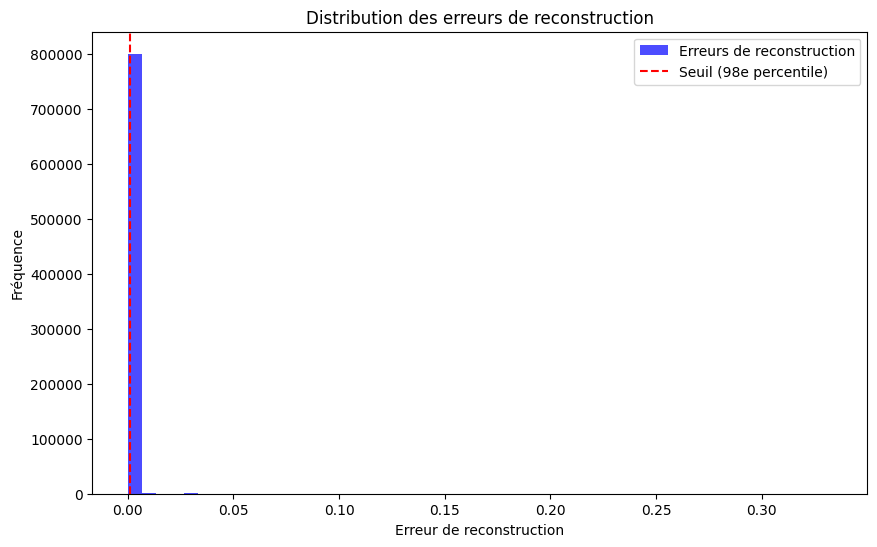

Nombre d'anomalies détectées : 40192


In [9]:
# Détection des anomalies
reconstructed = model.predict(sequences)
mse = np.mean(np.power(sequences - reconstructed, 2), axis=(1, 2))

# Visualisation des erreurs de reconstruction
plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, alpha=0.7, color="blue", label="Erreurs de reconstruction")
plt.axvline(
    np.percentile(mse, 98), color="red", linestyle="--", label="Seuil (98e percentile)"
)
plt.title("Distribution des erreurs de reconstruction")
plt.xlabel("Erreur de reconstruction")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

# Ajustement du seuil pour réduire les anomalies
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

# Marquer les anomalies dans les données originales
data_scaled["anomaly"] = 0
for i in range(len(anomalies)):
    if anomalies[i]:
        data_scaled.loc[i : i + sequence_length - 1, "anomaly"] = 1

print(f"Nombre d'anomalies détectées : {np.sum(anomalies)}")

In [10]:
from ipywidgets import Dropdown

# Création des widgets
file_selector = IntText(value=0, description="Fichier:")
plot_button = Button(description="Afficher")
output = Output()
# Création du widget Dropdown pour sélectionner un fichier
file_selector_dropdown = Dropdown(
    options=[f"Fichier {i + 1}" for i in range(len(all_files))],
    value="Fichier 1",
    description="Fichier:",
)


# Fonction pour afficher les données pour un fichier sélectionné
def afficher_donnees_par_fichier(change):
    with output:
        output.clear_output()  # Efface le contenu précédent
        selected_file_index = int(file_selector_dropdown.value.split(" ")[1]) - 1
        if selected_file_index < 0 or selected_file_index >= len(all_files):
            print("Fichier sélectionné invalide.")
            return

        # Charger les données du fichier sélectionné
        fichier_selectionne = all_files[selected_file_index]
        data = pd.read_csv(fichier_selectionne)

        # Prétraitement des données
        data_scaled = scaler.fit_transform(data[features])
        data_scaled = pd.DataFrame(data_scaled, columns=features)
        # Utilisation du modèle IsolationForest pour détecter les anomalies
        isolation_forest = IsolationForest(contamination=0.005, random_state=42)
        data_scaled["anomaly"] = isolation_forest.fit_predict(data_scaled[features])

        # Générer le graphique
        fig, ax = plt.subplots(figsize=(15, 5))
        for feature in features:
            ax.plot(data_scaled.index, data_scaled[feature], label=feature)

        # Ajouter une zone rouge pâle pour les anomalies
        anomalies_indices = data_scaled[data_scaled["anomaly"] == -1].index
        for start, end in zip(anomalies_indices[:-1], anomalies_indices[1:]):
            if (
                end - start > 1
            ):  # Si les indices ne sont pas consécutifs, démarrez une nouvelle zone
                ax.axvspan(start, end, color="red", alpha=0.2)

        ax.set_xlabel("Index")
        ax.set_ylabel("Valeurs des capteurs")
        ax.legend()
        ax.set_title(f"Visualisation des anomalies pour {file_selector_dropdown.value}")
        plt.show()


# Associer la fonction au widget
file_selector_dropdown.observe(afficher_donnees_par_fichier, names="value")

# Affichage des widgets
display(VBox([file_selector_dropdown, output]))


In [11]:
# Sauvegarde des résultats avec les anomalies détectées
output_path = "./anomalies_detected.csv"
data_scaled.to_csv(output_path, index=False)
print(f"Résultats sauvegardés dans {output_path}")

Résultats sauvegardés dans ./anomalies_detected.csv
